# XGBoost with Automatic Categorical Handling

This is the same as the other model except removing OHE and MixMax Scaler

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import warnings

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import xgboost as xgb

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_pickle('person_purchased.pkl')
df1.shape

(116483, 23)

In [3]:
df2 = pd.read_pickle('person_not.pkl')
df2.shape

(689983, 23)

In [4]:
df = pd.concat([df1, df2], axis=0)

In [5]:
df.shape

(806466, 23)

In [6]:
df["has_purchased"].value_counts()

0    689983
1    116483
Name: has_purchased, dtype: int64

In [7]:
df['first_utm_medium'] = df['first_utm_medium'].astype("category")
df['first_utm_source'] = df['first_utm_source'].astype("category")
df['last_utm_medium'] = df['last_utm_medium'].astype("category")
df['last_utm_source'] = df['last_utm_source'].astype("category")
df['source_category'] = df['source_category'].astype("category")
df['source_category_2'] = df['source_category_2'].astype("category")
df['source_category_3'] = df['source_category_3'].astype("category")

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 806466 entries, 0 to 689982
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   person_id                   806466 non-null  object  
 1   first_utm_medium            548495 non-null  category
 2   first_utm_source            548527 non-null  category
 3   multi_device                806466 non-null  int64   
 4   session_count               806466 non-null  int64   
 5   last_utm_medium             624153 non-null  category
 6   last_utm_source             624184 non-null  category
 7   source_category             806466 non-null  category
 8   source_category_2           440350 non-null  category
 9   source_category_3           97885 non-null   category
 10  seconds_since_first_vist    806466 non-null  float64 
 11  first_utm_content_distinct  806466 non-null  int64   
 12  first_utm_medium_distinct   806466 non-null  int64   
 13 

## Pearson's Correlation Heatmap

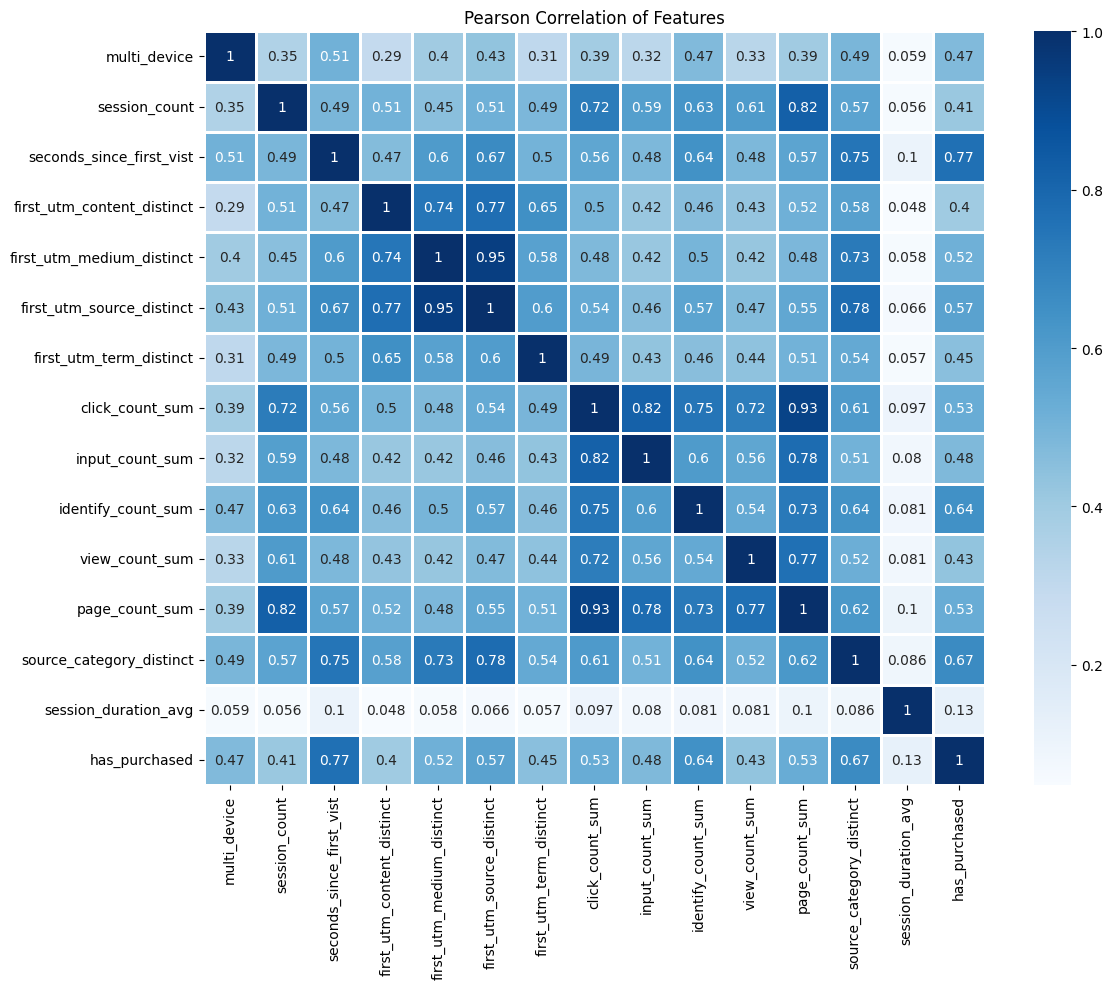

In [9]:
corr = df.corr(numeric_only=True)

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, cmap="Blues", annot=True, square=False, ax=ax,  linewidth = 1)
plt.title('Pearson Correlation of Features')
plt.tight_layout()
plt.savefig('02_correlation_matrix.png', dpi=300);

In [10]:
df_y = df['has_purchased']
df_X = df.drop(columns=['has_purchased', 'person_id', 'identify_count_sum'])

### Show an Example Record

In [11]:
df_X.iloc[0]

first_utm_medium               google_ads
first_utm_source                   search
multi_device                            0
session_count                           5
last_utm_medium                google_ads
last_utm_source                   display
source_category               Paid Search
source_category_2                 Branded
source_category_3                     NaN
seconds_since_first_vist      20218985.28
first_utm_content_distinct              1
first_utm_medium_distinct               1
first_utm_source_distinct               2
first_utm_term_distinct                 1
click_count_sum                        48
input_count_sum                         4
view_count_sum                          1
page_count_sum                         72
source_category_distinct                4
session_duration_avg                  4.6
Name: 0, dtype: object

## Preprocessing

In [12]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)

In [13]:
# count examples in each class
counter = Counter(df_y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 5.923


In [14]:
def create_pipe(clf):

    pipeline = Pipeline([('clf', clf)])

    return pipeline

## Evaluate Final Model

In [15]:
clf = xgb.XGBClassifier(random_state=42, 
                        verbosity=0, 
                        tree_method="hist",
                        enable_categorical=True)

pipeline = create_pipe(clf)

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [17]:
feat_list = []
xgb_cols = pipeline['clf'].get_booster().feature_names
feat_imp = pipeline['clf'].feature_importances_

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(xgb_cols, feat_imp):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['SUMMED_TOTAL'] = df_imp['IMPORTANCE'].cumsum()
df_imp.head(30)

,FEATURE,IMPORTANCE,SUMMED_TOTAL
15,input_count_sum,0.732606,0.732606
17,page_count_sum,0.091689,0.824294
9,seconds_since_first_vist,0.024781,0.849076
2,multi_device,0.020820,0.869895
14,click_count_sum,0.019013,0.888909
7,source_category_2,0.010866,0.899775
12,first_utm_source_distinct,0.010613,0.910388
3,session_count,0.010523,0.920911
6,source_category,0.010464,0.931375
16,view_count_sum,0.009715,0.941090


In [18]:
df_imp.to_csv('02_xgb_feature_importance_cats.csv', index=False)

## Test the Model

In [19]:
def print_confusion(pipeline):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    y_pred = pipeline.predict(X_test)

    print(metrics.classification_report(y_test, y_pred, digits=3))
        
    ConfusionMatrixDisplay.from_predictions(y_test, 
                                            y_pred, 
                                            cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('02_confusion_matrix.png', dpi=300);

              precision    recall  f1-score   support

           0      0.984     0.981     0.982    206899
           1      0.890     0.903     0.896     35041

    accuracy                          0.970    241940
   macro avg      0.937     0.942     0.939    241940
weighted avg      0.970     0.970     0.970    241940



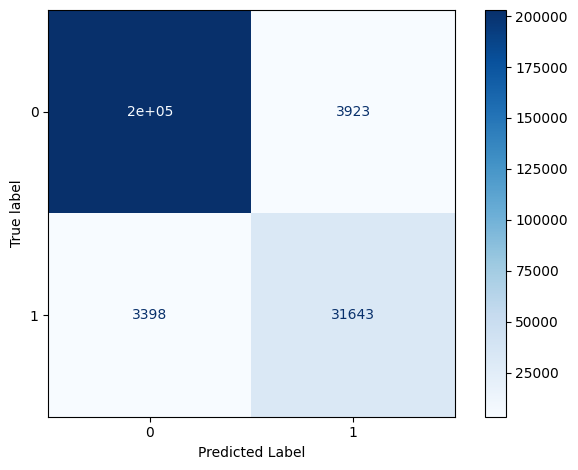

In [20]:
print_confusion(pipeline)

In [21]:
# Save the model to disk
dump(pipeline, '02_tf_first_purchase_cats.joblib') 

['02_tf_first_purchase_cats.joblib']